## 数据预处理

#### 读取数据

In [1]:
import pandas as pd
import numpy as np

# 读取数据
data_titleInfo = pd.read_csv('../dataset/Data_TitleInfo.csv')
data_studentInfo = pd.read_csv('../dataset/Data_StudentInfo.csv')

data_submitRecords = [pd.read_csv('../dataset/Data_SubmitRecord/SubmitRecord-Class%d.csv' % i) for i in range(1, 16)]
for i in range(1, 16):
    data_submitRecords[i-1]['class'] = f'Class{i}'
# 合并submitRecords
data_submitRecords = pd.concat(data_submitRecords)
data_submitRecords = data_submitRecords.reset_index(drop=True)
# 把数据中的index列改为index
data_submitRecords.replace('--', 0, inplace=True)
data_submitRecords.replace('-', 0, inplace=True)
data_submitRecords['state'].replace('�������', 'Error10', inplace=True)
data_submitRecords['timeconsume'] = data_submitRecords['timeconsume'].astype('int64')
data_submitRecords.to_csv('data_submitRecords.csv', index=False)

#### 生成题目数据特征

In [2]:
data_submitRecords.columns

Index(['index', 'class', 'time', 'state', 'score', 'title_ID', 'method',
       'memory', 'timeconsume', 'student_ID'],
      dtype='object')

In [55]:
# title 汇总信息
title_all_df = pd.DataFrame()
title_all_df['title_ID'] = data_titleInfo.groupby('title_ID')['title_ID'].max().values
title_all_df['score'] = data_titleInfo.groupby('title_ID')['score'].max().values
title_all_df['knowledge'] = data_titleInfo.groupby('title_ID')['knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
title_all_df['sub_knowledge'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
title_all_df['knowledge_num'] = data_titleInfo.groupby('title_ID')['knowledge'].count().values
title_all_df['sub_knowledge_num'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].count().values
title_all_df['t_sbmnum'] = data_submitRecords.groupby('title_ID')['title_ID'].count().values
title_all_df['t_mean_sbmnum'] = title_all_df['t_sbmnum'] / [(data_submitRecords[data_submitRecords['title_ID'] == title_id]).groupby('student_ID')['student_ID'].count().values.shape[0] for title_id in title_all_df['title_ID']]
title_all_df['t_mean_score'] = data_submitRecords.groupby('title_ID')['score'].mean().values / title_all_df['score'] * 100
title_all_df['t_mean_pfm_mem'] = (data_submitRecords[data_submitRecords['memory'] != 0]).groupby('title_ID')['memory'].mean().values
title_all_df['t_max_pfm_mem'] = (data_submitRecords[data_submitRecords['memory'] != 0]).groupby('title_ID')['memory'].max().values
title_all_df['t_min_pfm_mem'] = (data_submitRecords[data_submitRecords['memory'] != 0]).groupby('title_ID')['memory'].min().values
title_all_df['t_mean_pfm_tc'] = (data_submitRecords[data_submitRecords['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].mean().values
title_all_df['t_max_pfm_tc'] = (data_submitRecords[data_submitRecords['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].max().values
title_all_df['t_min_pfm_tc'] = (data_submitRecords[data_submitRecords['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].min().values
title_all_df['t_subtime_f'] = data_submitRecords.groupby('title_ID')['time'].min().values.astype('datetime64[s]')
title_all_df['t_subtime_l'] = data_submitRecords.groupby('title_ID')['time'].max().values.astype('datetime64[s]')
title_all_df['t_period'] = title_all_df['t_subtime_l'] - title_all_df['t_subtime_f']
title_all_df['t_methodNum'] = [(data_submitRecords[data_submitRecords['title_ID'] == title_id]).groupby('method')['method'].count().values for title_id in title_all_df['title_ID']]
title_all_df.insert(0, 'index', title_all_df.index)
title_all_df.to_csv('./题目数据特征/titles_all.csv', index=False)


In [56]:
# title 分班信息
title_sep_dfs = []
for i in range(1, 16):
    cur_class_records = data_submitRecords[data_submitRecords['class'] == f'Class{i}']
    title_df = pd.DataFrame()
    title_df['title_ID'] = data_titleInfo.groupby('title_ID')['title_ID'].max().values
    title_df['score'] = data_titleInfo.groupby('title_ID')['score'].max().values
    title_df['knowledge'] = data_titleInfo.groupby('title_ID')['knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
    title_df['sub_knowledge'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
    title_df['knowledge_num'] = data_titleInfo.groupby('title_ID')['knowledge'].count().values
    title_df['sub_knowledge_num'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].count().values
    title_df['t_sbmnum'] = cur_class_records.groupby('title_ID')['title_ID'].count().values
    title_df['t_mean_sbmnum'] = title_df['t_sbmnum'] / [(cur_class_records[cur_class_records['title_ID'] == title_id]).groupby('student_ID')['student_ID'].count().values.shape[0] for title_id in title_df['title_ID']]
    title_df['t_mean_score'] = cur_class_records.groupby('title_ID')['score'].mean().values / title_df['score'] * 100
    title_df['t_mean_pfm_mem'] = (cur_class_records[cur_class_records['memory'] != 0]).groupby('title_ID')['memory'].mean().values
    title_df['t_max_pfm_mem'] = (cur_class_records[cur_class_records['memory'] != 0]).groupby('title_ID')['memory'].max().values
    title_df['t_min_pfm_mem'] = (cur_class_records[cur_class_records['memory'] != 0]).groupby('title_ID')['memory'].min().values
    title_df['t_mean_pfm_tc'] = (cur_class_records[cur_class_records['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].mean().values
    title_df['t_max_pfm_tc'] = (cur_class_records[cur_class_records['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].max().values
    title_df['t_min_pfm_tc'] = (cur_class_records[cur_class_records['timeconsume'] != 0]).groupby('title_ID')['timeconsume'].min().values
    title_df['t_subtime_f'] = cur_class_records.groupby('title_ID')['time'].min().values.astype('datetime64[s]')
    title_df['t_subtime_l'] = cur_class_records.groupby('title_ID')['time'].max().values.astype('datetime64[s]')
    title_df['t_period'] = title_df['t_subtime_l'] - title_df['t_subtime_f']
    title_df['t_methodNum'] = [(cur_class_records[cur_class_records['title_ID'] == title_id]).groupby('method')['method'].count().values for title_id in title_df['title_ID']]
    title_df.insert(0, 'index', title_df.index)
    title_sep_dfs.append(title_df)
    title_df.to_csv(f'./题目数据特征/titles_class{i}.csv', index=False)

In [5]:
title_sep_df = pd.DataFrame()
title_sep_df['title_ID'] = data_titleInfo.groupby('title_ID')['title_ID'].max().values
title_sep_df['score'] = data_titleInfo.groupby('title_ID')['score'].max().values
title_sep_df['knowledge'] = data_titleInfo.groupby('title_ID')['knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
title_sep_df['sub_knowledge'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].aggregate(lambda x: ' '.join(x.tolist())).values
title_sep_df['knowledge_num'] = data_titleInfo.groupby('title_ID')['knowledge'].count().values
title_sep_df['sub_knowledge_num'] = data_titleInfo.groupby('title_ID')['sub_knowledge'].count().values
for col in title_all_df.columns:
    if 't_' in col:
        title_sep_df[col] = np.concatenate(tuple([title_sep_dfs[i][col].to_numpy().reshape(-1, 1) for i in range(15)]), axis=1).tolist()
title_sep_df.insert(0, 'index', title_sep_df.index)
# title_sep_df.to_csv('titles_sep.csv', index=False)

#### 计算人-题数据

In [44]:
# student学号列表
stu_ids = data_studentInfo['student_ID'].values.tolist()
stu_ids = list(set(stu_ids))
stu_ids.sort()
# title题目列表
title_ids = data_titleInfo['title_ID'].values.tolist()
title_ids = list(set(title_ids))
title_ids.sort()

In [50]:
def get_title_attribute(title_id, attribute):
    return title_all_df[title_all_df['title_ID'] == title_id][attribute].values[0]

In [94]:
# 计算人题数据
stu_title_df = pd.DataFrame(columns=['title_ID', 'student_ID', 'class', 'st_score', 'st_pfm_tc', 'st_pfm_mem', 'st_errs', 'st_testNum', 'st_exploreNum', 'st_time_f', 'st_time_best', 'st_time_l', 'st_time_mean'])

from tqdm import tqdm
for title_id in title_ids:
    title_info = {}
    title_info['score'] = get_title_attribute(title_id, 'score')
    filtered_submits = data_submitRecords[(data_submitRecords['title_ID'] == title_id) & (data_submitRecords['score'] == title_info['score'])]
    title_info['ac_tc_min'] = filtered_submits['timeconsume'].min()
    title_info['ac_tc_max'] = filtered_submits['timeconsume'].max()
    title_info['ac_mem_min'] = filtered_submits['memory'].min()
    title_info['ac_mem_max'] = filtered_submits['memory'].max()
    for i in range(1, 16):
        filtered_submits = data_submitRecords[(data_submitRecords['title_ID'] == title_id) & (data_submitRecords['class'] == f'Class{i}')]
        title_info[f'Class{i}'] = [filtered_submits['time'].min(), filtered_submits['time'].max(), filtered_submits['time'].max() - filtered_submits['time'].min()]
    for student_id in tqdm(stu_ids):
        cur_row = {}
        cur_row['title_ID'] = title_id
        cur_row['student_ID'] = student_id
        filtered_submits = data_submitRecords[(data_submitRecords['student_ID'] == student_id) & (data_submitRecords['title_ID'] == title_id)].sort_values(by='time')
        if filtered_submits.shape[0] == 0:
            continue
        cur_row['class'] = filtered_submits['class'].values[0]
        # st_score
        max_score = filtered_submits['score'].max()
        cur_row['st_score'] = max_score / title_info['score']
        # st_pfm_tc & st_pfm_mem
        if cur_row['st_score'] == 1:
            best_tc = filtered_submits[filtered_submits['score'] == max_score]['timeconsume'].min()
            best_mem = filtered_submits[filtered_submits['score'] == max_score]['memory'].min()
            cur_row['st_pfm_tc'] = 1 - ((best_tc - title_info['ac_tc_min']) / (title_info['ac_tc_max'] - title_info['ac_tc_min']))
            cur_row['st_pfm_mem'] = 1 - ((best_mem - title_info['ac_mem_min']) / (title_info['ac_mem_max'] - title_info['ac_mem_min']))
        else:
            cur_row['st_pfm_tc'] = 0
            cur_row['st_pfm_mem'] = 0
        # st_errs
        cur_row['st_errs'] = np.unique(filtered_submits[filtered_submits['state'] != 'Absolutely_Correct']['state']).shape[0]
        # st_testNum & st_exploreNum
        submit_num = filtered_submits.shape[0]
        if (filtered_submits['state'] == 'Absolutely_Correct').max():
            # 有ac
            cur_row['st_testNum'] = (filtered_submits['state'] == 'Absolutely_Correct').astype(int).argmax()
            cur_row['st_exploreNum'] = submit_num - 1 - cur_row['st_testNum']
        else:
            # 没ac
            cur_row['st_testNum'] = submit_num
            cur_row['st_exploreNum'] = 0
        # st_time_*
        cur_row['st_time_f'] = (filtered_submits['time'].min() - title_info[cur_row['class']][0]) / title_info[cur_row['class']][2]
        cur_row['st_time_l'] = (filtered_submits['time'].max() - title_info[cur_row['class']][0]) / title_info[cur_row['class']][2]
        cur_row['st_time_mean'] = (filtered_submits['time'].mean() - title_info[cur_row['class']][0]) / title_info[cur_row['class']][2]
        cur_row['st_time_best'] = (filtered_submits[filtered_submits['score'] == max_score]['time'].min() - title_info[cur_row['class']][0]) / title_info[cur_row['class']][2]
        cur_row = pd.DataFrame([cur_row])
        stu_title_df = pd.concat([stu_title_df, cur_row], ignore_index=True)
stu_title_df.to_csv('./人题数据/stu_title.csv', index=False)



100%|██████████| 1364/1364 [01:06<00:00, 20.39it/s]


In [97]:
stu_title_df.drop(columns=['st_time_bestst_time_l'], inplace=True)
stu_title_df.to_csv('./人题数据/stu_title.csv', index=False)

In [106]:
# 添加排名信息
stu_title_df['st_rank'] = 0
for row_id, row in tqdm(stu_title_df.iterrows()):
    cur_title_id = row['title_ID']
    cur_class = row['class']
    cur_score = row['st_score']
    cur_student_id = row['student_ID']
    cur_class_df = stu_title_df[(stu_title_df['title_ID'] == cur_title_id) & (stu_title_df['class'] == cur_class)]
    cur_class_df = cur_class_df.sort_values(by=['st_score', 'st_time_best'], ascending=[False, True])
    row['st_rank'] = (cur_class_df['student_ID'] == cur_student_id).astype(int).argmax()
    row['st_rank'] /= (cur_class_df.shape[0] - 1)
    stu_title_df.loc[row_id, 'st_rank'] = row['st_rank']

50482it [04:10, 201.51it/s]


In [ ]:
# 添加题目分值
stu_title_df.insert(1, 'score', 0)

In [119]:
for title_id in title_ids:
    score = get_title_attribute(title_id, 'score')
    stu_title_df.loc[stu_title_df['title_ID'] == title_id, 'score'] = score
stu_title_df.to_csv('./人题数据/stu_title.csv', index=False)

#### 学生特征数据

In [173]:
title_info = {}
for i in title_ids:
    title_info[i] = get_title_attribute(i, 'score')
stu_df = pd.DataFrame()
cols = stu_title_df.columns.values[4:]
for student_id in tqdm(stu_ids):
    row = {}
    row['student_ID'] = student_id
    filtered_rows = stu_title_df[stu_title_df['student_ID'] == student_id].sort_values(by='title_ID', ascending = True)
    row['class'] = filtered_rows['class'].values[0]
    weighted = []
    for t_id in filtered_rows['title_ID'].values:
        weighted.append(title_info[t_id])
    weighted = np.array(weighted).reshape(-1, 1)
    row_content = (((weighted * filtered_rows[cols].to_numpy()).sum(axis=0)) / weighted.sum())
    for i, col in enumerate(cols):
        row[col] = row_content[i]
    row = pd.DataFrame([row])
    stu_df = pd.concat([stu_df, row], ignore_index=True)

100%|██████████| 1364/1364 [00:04<00:00, 320.81it/s]


In [174]:
data_studentInfo.sort_values(by='student_ID', inplace=True)
stu_df.insert(1, 'major', data_studentInfo['major'].values)
stu_df.insert(1, 'age', data_studentInfo['age'].values)
stu_df.insert(1, 'sex', data_studentInfo['sex'].values)

In [175]:
stu_df

,student_ID,sex,age,major,class,st_score,st_pfm_tc,st_pfm_mem,st_errs,st_testNum,st_exploreNum,st_time_f,st_time_mean,st_time_l,st_time_best,st_rank
0,0088dc183f73c83f763e,female,20,J40192,Class2,1.000000,0.950476,0.741791,1.330000,3.870000,0.160000,0.513852,0.537872,0.560742,0.540857,0.553622
1,00cbf05221bb479e66c3,female,19,J23517,Class10,1.000000,0.911420,0.724297,1.930000,4.060000,0.380000,0.552667,0.559211,0.562357,0.562006,0.496003
2,00df647ee4bf7173642f,male,23,J57489,Class14,1.000000,0.915866,0.670086,2.390000,11.370000,0.750000,0.264084,0.289072,0.341979,0.338754,0.278742
3,0107f72b66cbd1a0926d,female,20,J87654,Class5,1.000000,0.948442,0.778892,0.990000,1.970000,0.060000,0.433713,0.442666,0.452027,0.452026,0.325762
4,011d454f199c123d44ad,male,22,J78901,Class3,1.000000,0.969072,0.759228,1.450000,4.390000,0.090000,0.732619,0.736857,0.740483,0.740481,0.612422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,zq3xohaut5o9dbd9064z,male,19,J57489,Class6,0.625000,0.529416,0.416403,1.916667,2.354167,0.822917,0.287699,0.458334,0.628418,0.426168,0.626945
1360,zse4s5wowlo5xntqyqb4,female,24,J40192,Class10,0.820000,0.689271,0.546344,1.760000,1.450000,2.030000,0.230624,0.454052,0.653396,0.375032,0.461809
1361,zuw35j06tzftt6oon4c5,female,19,J40192,Class6,0.731959,0.628812,0.481332,2.154639,1.958763,1.628866,0.247226,0.453793,0.647750,0.366770,0.479870
1362,zyfp520tbnq5p2pvrkin,female,18,J23517,Class2,0.793814,0.714803,0.599110,1.701031,1.381443,1.721649,0.382263,0.503850,0.634502,0.457068,0.541778


In [156]:
stu_df.to_csv('./人题数据/stu.csv', index=False)

#### 聚类

In [181]:
students_df = stu_df.copy()

cols = students_df.columns
numeric_features = cols[5:]

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from kmodes.kprototypes import KPrototypes

# 标准化数值特征
scaler = StandardScaler()
students_df[numeric_features] = scaler.fit_transform(students_df[numeric_features])

# 使用 K-prototypes 进行聚类
data_for_clustering = students_df[cols[1:]].values.astype(object)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 129, ncost: 13191.60248098181
Run: 1, iteration: 2/100, moves: 26, ncost: 13169.426685747583
Run: 1, iteration: 3/100, moves: 18, ncost: 13160.932226252768
Run: 1, iteration: 4/100, moves: 11, ncost: 13157.11043448067
Run: 1, iteration: 5/100, moves: 8, ncost: 13155.892505446674
Run: 1, iteration: 6/100, moves: 4, ncost: 13155.461639045037
Run: 1, iteration: 7/100, moves: 2, ncost: 13155.376936711084
Run: 1, iteration: 8/100, moves: 0, ncost: 13155.376936711084
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 172, ncost: 13159.065192917817
Run: 2, iteration: 2/100, moves: 23, ncost: 13151.48957649231
Run: 2, iteration: 3/100, moves: 9, ncost: 13150.014774444864
Run: 2, iteration: 4/100, moves: 2, ncost: 13149.949024421474
Run: 2, iteration: 5/100, moves: 0, ncost: 13149.949024421474
Init: initializing centroids


c:\Users\QishuoBai\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36718 (\N{CJK UNIFIED IDEOGRAPH-8F6E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\QishuoBai\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24275 (\N{CJK UNIFIED IDEOGRAPH-5ED3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\QishuoBai\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\QishuoBai\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\QishuoBai\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from current font.
  fig.canvas

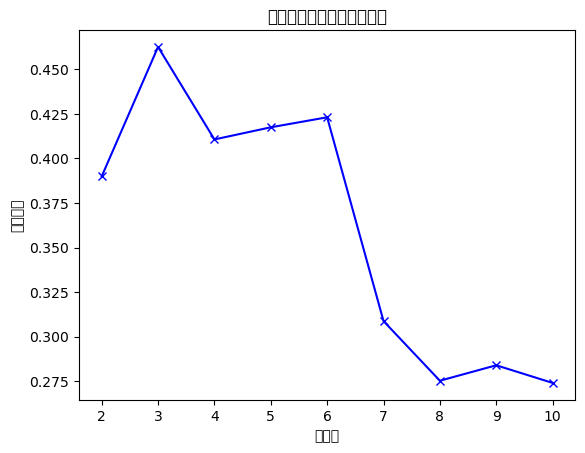

In [182]:
from sklearn.metrics import silhouette_score

# 使用 Silhouette Score 来确定最佳聚类数
silhouette_scores = []

# 遍历不同的聚类数
for k in range(2, 11):
    kproto = KPrototypes(n_clusters=k, init='Huang', n_init=10, verbose=1)
    clusters = kproto.fit_predict(data_for_clustering, categorical=[0, 1, 2, 3])
    # 计算轮廓系数
    numeric_part = data_for_clustering[:, 4:].astype(float)
    score = silhouette_score(numeric_part, clusters)
    silhouette_scores.append(score)

import matplotlib.pyplot as plt
# 绘制 Silhouette Scores 图
plt.plot(range(2, 11), silhouette_scores, 'bx-')
plt.xlabel('聚类数')
plt.ylabel('轮廓系数')
plt.title('轮廓系数来确定最佳聚类数')
plt.show()

In [183]:
kproto = KPrototypes(n_clusters=3, init='Huang', n_init=10, verbose=1)
clusters = kproto.fit_predict(data_for_clustering, categorical=[0, 1, 2, 3])
students_df['cluster'] = clusters

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 162, ncost: 8350.798831219732
Run: 1, iteration: 2/100, moves: 53, ncost: 8267.654608048748
Run: 1, iteration: 3/100, moves: 22, ncost: 8249.443127079905
Run: 1, iteration: 4/100, moves: 10, ncost: 8246.542601113804
Run: 1, iteration: 5/100, moves: 4, ncost: 8246.086460159975
Run: 1, iteration: 6/100, moves: 0, ncost: 8246.086460159975
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 497, ncost: 8505.43820509052
Run: 2, iteration: 2/100, moves: 145, ncost: 8250.712869478835
Run: 2, iteration: 3/100, moves: 12, ncost: 8246.810976268012
Run: 2, iteration: 4/100, moves: 3, ncost: 8246.223810035637
Run: 2, iteration: 5/100, moves: 2, ncost: 8246.086460159975
Run: 2, iteration: 6/100, moves: 0, ncost: 8246.086460159975
Init: initializing centroids
Init: initial

In [184]:
students_df

,student_ID,sex,age,major,class,st_score,st_pfm_tc,st_pfm_mem,st_errs,st_testNum,st_exploreNum,st_time_f,st_time_mean,st_time_l,st_time_best,st_rank,cluster
0,0088dc183f73c83f763e,female,20,J40192,Class2,0.769672,0.847143,0.786074,-0.061554,0.479871,-0.713464,0.407659,0.145963,-0.202530,0.272967,0.269652,2
1,00cbf05221bb479e66c3,female,19,J23517,Class10,0.769672,0.620669,0.660697,0.945760,0.565203,-0.469026,0.595767,0.269127,-0.193633,0.387033,-0.037006,2
2,00df647ee4bf7173642f,male,23,J57489,Class14,0.769672,0.646450,0.272170,1.718035,3.848213,-0.057925,-0.802786,-1.290012,-1.407811,-0.817045,-1.193308,1
3,0107f72b66cbd1a0926d,female,20,J87654,Class5,0.769672,0.835345,1.051968,-0.632366,-0.373442,-0.824573,0.019284,-0.403530,-0.801501,-0.206127,-0.943055,1
4,011d454f199c123d44ad,male,22,J78901,Class3,0.769672,0.954975,0.911039,0.139908,0.713410,-0.791240,1.467863,1.294429,0.787762,1.349613,0.582591,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,zq3xohaut5o9dbd9064z,male,19,J57489,Class6,-1.775190,-1.594420,-1.545953,0.923376,-0.200908,0.023092,-0.688340,-0.313099,0.170335,-0.345593,0.659883,0
1360,zse4s5wowlo5xntqyqb4,female,24,J40192,Class10,-0.451862,-0.667487,-0.614678,0.660354,-0.606980,1.364263,-0.964943,-0.337813,0.307951,-0.621386,-0.218993,0
1361,zuw35j06tzftt6oon4c5,female,19,J40192,Class6,-1.049336,-1.018066,-1.080613,1.322898,-0.378489,0.918569,-0.884487,-0.339309,0.276844,-0.665946,-0.122868,0
1362,zyfp520tbnq5p2pvrkin,female,18,J23517,Class2,-0.629565,-0.519436,-0.236513,0.561354,-0.637770,1.021659,-0.230056,-0.050399,0.203859,-0.178939,0.206615,0


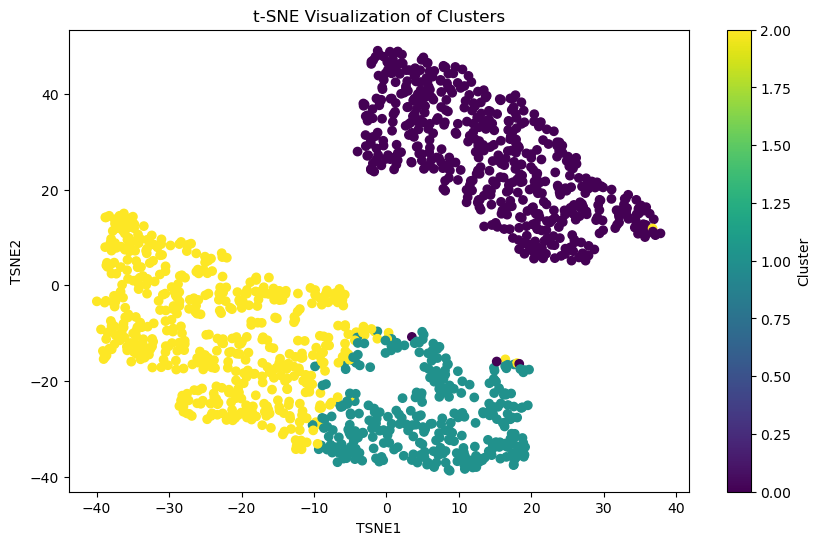

In [189]:
from sklearn.manifold import TSNE

# 进行 PCA 降维到 2 维
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(students_df[students_df.columns[5:-1]])
# 创建一个包含 t-SNE 结果和聚类标签的新 DataFrame
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['cluster'] = students_df['cluster']

# 可视化 t-SNE 结果
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['cluster'], cmap='viridis')
plt.colorbar(scatter, label='Cluster')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

In [195]:
tsne_df['student_ID'] = students_df['student_ID']
tsne_df.to_csv('./人题数据/stu_tsne_3.csv', index=False)